# Final Project Data Wrangling

## A. Pendahuluan
- **Deskripsi dataset**: 'NFL Stadium Attendance', sebuah pak dataset(terdiri dari tiga sub dataset) yang mencatat *Pro Football Reference team standings*. Ada **tiga** buah sub dataset, yaitu:
    1. `attendance.csv` yang berisi kehadiran tim secara mingguan,
    2. `standings.csv` yang berisi hasil komputasi pertandingan tim, dan
    3. `games.csv` yang berisi data pertandingan antara tim yang mentah.

    Ketiga dataset tersebut bisa digabungkan melalui kolom `year`, `team_name`, dan `team`.
- **Alasan dataset menarik**: Seperti yang telah kami sebutkan, dataset ini memiliki **tiga sub dataset** yang di mana bisa **digabungkan** serta kategori **dataset** seperti ini belum pernah kami olah sebelumnya. Dan juga untuk `standings.csv` adalah dataset yang berisi hasil komputasi, yang biasanya dataset umumnya benar-benar murni/mentah namun kami disajikan dengan **dua sub dataset mentah** dan **satu sub dataset yang diolah**.

- **Pertanyaan/tujuan analisis**:
    1.  **Analisis Bisnis & Pasar**: Sejauh mana kualitas performa tim (seperti *Winning Rate* dan *Offensive Ranking*) mempengaruhi loyalitas penggemar dan penjualan tiket? Apakah tim yang bermain buruk selalu ditinggalkan penontonnya?
    2.  **Analisis Strategi Juara**: Apa profil statistik yang membedakan seorang Juara Superbowl dengan tim rata-rata? Apakah serangan (*Offense*) lebih krusial daripada pertahanan (*Defense*) dalam meraih gelar juara?
    3.  **Analisis Faktor Eksternal & Mitos**: Bagaimana faktor di luar kendali pelatih—seperti cuaca (bulan pertandingan), jadwal tayang (*Primetime*), dan jumlah penonton di stadion—mempengaruhi hasil akhir skor pertandingan?

    **Tujuan:**
    - Mengukur dampak ekonomi dari performa tim terhadap *weekly attendance*.
    - Mengidentifikasi "DNA Juara" menggunakan *Simple Rating System (SRS)* untuk mematahkan mitos strategi.
    - Mengevaluasi mitos "Pemain ke-12" (dampak jumlah penonton terhadap margin kemenangan).

## B. Setup \& Package
### 1. Import library & penyesuaian lingkungan notebook
Pada sel berikut kami impor library yang akan digunakan dan melakukan penyesuaian terhadap notebook kami.

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

### 2. Penyimpanan path file
Setelah mengimpor library, kami melakukan setup *path* untuk membaca serta menulis dataset.

In [122]:
raw_path = {
    'attendance': '../data/raw/attendance.csv',
    'games': '../data/raw/games.csv',
    'standings': '../data/raw/standings.csv'
}

processed_path = '../data/processed/nfl.csv'


### 3. Penjelasan fungsi paket
- `pandas (pd)`: -
- `numpy (np)`: -
- `matplotlib.pyplot (plt)`: -
- `seaborn (sns)`: -

## C. Data Preparation

### 1. Baca dataset dari data yang ada sesuai *path*

In [123]:
attendance = pd.read_csv(raw_path['attendance'])
games = pd.read_csv(raw_path['games'])
standings = pd.read_csv(raw_path['standings'])

### 2. Proses *Cleaning* dan *Data Wrangling*
- Pembuatan function untuk melakukan *checking* pada dataset:

In [124]:
def cek_data(df):
    print("\nDimensi:",df.shape)
    print("\nTipe Data:\n",df.dtypes)
    print("\nMissing Values:\n",df.isnull().sum())
    print("\nDuplicates:",df.duplicated().sum())

- Pengecekan awal untuk dataset `games`:

In [125]:
print("==== Tahap Pengecekan Awal untuk Data games ====")
cek_data(games)
print("=" * 40, "\n")

==== Tahap Pengecekan Awal untuk Data games ====

Dimensi: (5324, 19)

Tipe Data:
 year               int64
week              object
home_team         object
away_team         object
winner            object
tie               object
day               object
date              object
time              object
pts_win            int64
pts_loss           int64
yds_win            int64
turnovers_win      int64
yds_loss           int64
turnovers_loss     int64
home_team_name    object
home_team_city    object
away_team_name    object
away_team_city    object
dtype: object

Missing Values:
 year                 0
week                 0
home_team            0
away_team            0
winner               0
tie               5314
day                  0
date                 0
time                 0
pts_win              0
pts_loss             0
yds_win              0
turnovers_win        0
yds_loss             0
turnovers_loss       0
home_team_name       0
home_team_city       0
away_team_name     

- Identifikasi setelah pengecekan `games`:
    - Kolom `date` bertipe data `object`, harus diganti menjadi `date` untuk analisis deret waktu yang baik.
    - Kolom `week` bertipe data `object` karena di baris bawah ada data yang berupa istilah. Daripada memformat kolom, kami tambahkan kolom baru yaitu `week_num`.
    - Kolom `tie` banyak missing value, harus diganti dengan `0` untuk menandakan tidak adanya kejadian seri/*tie*.
    - Kolom `time` bertipe data `object`. Akan kami biarkan karena `time` sendiri ambigu karena ada banyak `date`. Kami akan buat kolom baru untuk analisis bernama `kickoff_time`.

- Prosedur penanganan untuk `games`:

In [126]:
games = pd.read_csv(raw_path['games']) # load dataset lagi untuk mencegah error

# Buat kolom dummy untuk ubah tipe data kolom date
games['full_date_str'] = games['date'].astype(str) + ', ' + games['year'].astype(str)

# Ubah tipe data ke datetime
games['date'] = pd.to_datetime(games['full_date_str'])

# Membuat kolom kickoff_time
games['kickoff_time'] = pd.to_datetime(
    games['date'].astype(str) + ' ' + games['time'],
    format='%Y-%m-%d %I:%M%p',
    errors = 'coerce'
)

# Pemetaan kolom week object ke integer
week_map = {
    'WildCard':18,
    'Division':19,
    'ConfChamp':20,
    'SuperBowl':21
}

# Membuat kolom week_num
games['week_num'] = games['week'].replace(week_map).astype(int)

# Mengisi kolom tie yang kosong dengan 0
games['tie'] = games['tie'].fillna(0)

# Cek akhir
print("==== Cek Akhir untuk Data games ====")
cek_data(games)
print("=" * 40, "\n")

==== Cek Akhir untuk Data games ====

Dimensi: (5324, 22)

Tipe Data:
 year                       int64
week                      object
home_team                 object
away_team                 object
winner                    object
tie                       object
day                       object
date              datetime64[ns]
time                      object
pts_win                    int64
pts_loss                   int64
yds_win                    int64
turnovers_win              int64
yds_loss                   int64
turnovers_loss             int64
home_team_name            object
home_team_city            object
away_team_name            object
away_team_city            object
full_date_str             object
kickoff_time      datetime64[ns]
week_num                   int64
dtype: object

Missing Values:
 year              0
week              0
home_team         0
away_team         0
winner            0
tie               0
day               0
date              0
time       

In [127]:
print("Data games setelah dibersihkan:")
games

Data games setelah dibersihkan:


,year,week,home_team,away_team,winner,tie,day,date,time,pts_win,pts_loss,yds_win,turnovers_win,yds_loss,turnovers_loss,home_team_name,home_team_city,away_team_name,away_team_city,full_date_str,kickoff_time,week_num
0,2000,1,Minnesota Vikings,Chicago Bears,Minnesota Vikings,0,Sun,2000-09-03,1:00PM,30,27,374,1,425,1,Vikings,Minnesota,Bears,Chicago,"September 3, 2000",2000-09-03 13:00:00,1
1,2000,1,Kansas City Chiefs,Indianapolis Colts,Indianapolis Colts,0,Sun,2000-09-03,1:00PM,27,14,386,2,280,1,Chiefs,Kansas City,Colts,Indianapolis,"September 3, 2000",2000-09-03 13:00:00,1
2,2000,1,Washington Redskins,Carolina Panthers,Washington Redskins,0,Sun,2000-09-03,1:01PM,20,17,396,0,236,1,Redskins,Washington,Panthers,Carolina,"September 3, 2000",2000-09-03 13:01:00,1
3,2000,1,Atlanta Falcons,San Francisco 49ers,Atlanta Falcons,0,Sun,2000-09-03,1:02PM,36,28,359,1,339,1,Falcons,Atlanta,49ers,San Francisco,"September 3, 2000",2000-09-03 13:02:00,1
4,2000,1,Pittsburgh Steelers,Baltimore Ravens,Baltimore Ravens,0,Sun,2000-09-03,1:02PM,16,0,336,0,223,1,Steelers,Pittsburgh,Ravens,Baltimore,"September 3, 2000",2000-09-03 13:02:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5319,2019,Division,Kansas City Chiefs,Houston Texans,Kansas City Chiefs,0,Sun,2019-01-12,3:05PM,51,31,434,1,442,1,Chiefs,Kansas City,Texans,Houston,"January 12, 2019",2019-01-12 15:05:00,19
5320,2019,Division,Green Bay Packers,Seattle Seahawks,Green Bay Packers,0,Sun,2019-01-12,6:40PM,28,23,344,0,375,0,Packers,Green Bay,Seahawks,Seattle,"January 12, 2019",2019-01-12 18:40:00,19
5321,2019,ConfChamp,Kansas City Chiefs,Tennessee Titans,Kansas City Chiefs,0,Sun,2019-01-19,3:05PM,35,24,404,0,295,0,Chiefs,Kansas City,Titans,Tennessee,"January 19, 2019",2019-01-19 15:05:00,20
5322,2019,ConfChamp,San Francisco 49ers,Green Bay Packers,San Francisco 49ers,0,Sun,2019-01-19,6:40PM,37,20,354,0,358,3,49ers,San Francisco,Packers,Green Bay,"January 19, 2019",2019-01-19 18:40:00,20


- Pengecekan awal untuk dataset `attendance`:

In [128]:
print("==== Tahap Pengecekan Awal untuk Data attendance ====")
cek_data(attendance)
print("=" * 40, "\n")

==== Tahap Pengecekan Awal untuk Data attendance ====

Dimensi: (10846, 8)

Tipe Data:
 team                  object
team_name             object
year                   int64
total                  int64
home                   int64
away                   int64
week                   int64
weekly_attendance    float64
dtype: object

Missing Values:
 team                   0
team_name              0
year                   0
total                  0
home                   0
away                   0
week                   0
weekly_attendance    638
dtype: int64

Duplicates: 0



- Identifikasi setelah pengecekan `attendance`:
    - Kolom `weekly_attendance` ada 638 missing values, harus di*drop* karena tidak ada permainan yang berlangsung pada waktu itu.
    - Kolom yang sama bertipe data `float64`, harus dikonversi ke `int64` karena jumlah *attendance* tidak mungkin desimal.

- Prosedur penanganan untuk `attendance`:

In [129]:
# Drop missing value
attendance.dropna(subset=['weekly_attendance'], inplace=True)

# Memperbaiki tipe data
attendance['weekly_attendance'] = attendance['weekly_attendance'].astype(int)

# Cek akhir
print("==== Cek Akhir untuk Data attendance ====")
cek_data(attendance)
print("=" * 40, "\n")

==== Cek Akhir untuk Data attendance ====

Dimensi: (10208, 8)

Tipe Data:
 team                 object
team_name            object
year                  int64
total                 int64
home                  int64
away                  int64
week                  int64
weekly_attendance     int64
dtype: object

Missing Values:
 team                 0
team_name            0
year                 0
total                0
home                 0
away                 0
week                 0
weekly_attendance    0
dtype: int64

Duplicates: 0



In [130]:
print("Data attendance setelah dibersihkan:")
attendance

Data attendance setelah dibersihkan:


,team,team_name,year,total,home,away,week,weekly_attendance
0,Arizona,Cardinals,2000,893926,387475,506451,1,77434
1,Arizona,Cardinals,2000,893926,387475,506451,2,66009
3,Arizona,Cardinals,2000,893926,387475,506451,4,71801
4,Arizona,Cardinals,2000,893926,387475,506451,5,66985
5,Arizona,Cardinals,2000,893926,387475,506451,6,44296
...,...,...,...,...,...,...,...,...
10841,Washington,Redskins,2019,1101466,523906,577560,13,71504
10842,Washington,Redskins,2019,1101466,523906,577560,14,77296
10843,Washington,Redskins,2019,1101466,523906,577560,15,63246
10844,Washington,Redskins,2019,1101466,523906,577560,16,66083


- Pengecekan awal untuk dataset `standings`:

In [131]:
print("==== Tahap Pengecekan Awal untuk Data standings ====")
cek_data(standings)
print("=" * 40)

==== Tahap Pengecekan Awal untuk Data standings ====

Dimensi: (638, 15)

Tipe Data:
 team                     object
team_name                object
year                      int64
wins                      int64
loss                      int64
points_for                int64
points_against            int64
points_differential       int64
margin_of_victory       float64
strength_of_schedule    float64
simple_rating           float64
offensive_ranking       float64
defensive_ranking       float64
playoffs                 object
sb_winner                object
dtype: object

Missing Values:
 team                    0
team_name               0
year                    0
wins                    0
loss                    0
points_for              0
points_against          0
points_differential     0
margin_of_victory       0
strength_of_schedule    0
simple_rating           0
offensive_ranking       0
defensive_ranking       0
playoffs                0
sb_winner               0
dtype: int64

- Identifikasi setelah pengecekan `standings`:
    -  Tidak ada kejanggalan yang ditemukan sejauh ini tapi kami akan melakukan koreksi nama kolom untuk penggabungan dataset.

- Prosedur penanganan untuk `standings`:

In [132]:
standing = standings.rename(
    columns={
        'wins': 'seasons_wins',
        'loss': 'season_losses',
        'simple_rating': 'season_rating',
        'offensive_rating': 'off-rank',
        'defensive_ranking': 'def_rank',
        'sb_winner': 'superbowl_winner'
    }
)

### 3. Identifikasi yang lain (*outlier checking*)
- Pengecekan dilakukan pada data `attendance` dan `games` karena keduanya adalah data mentah/murni.


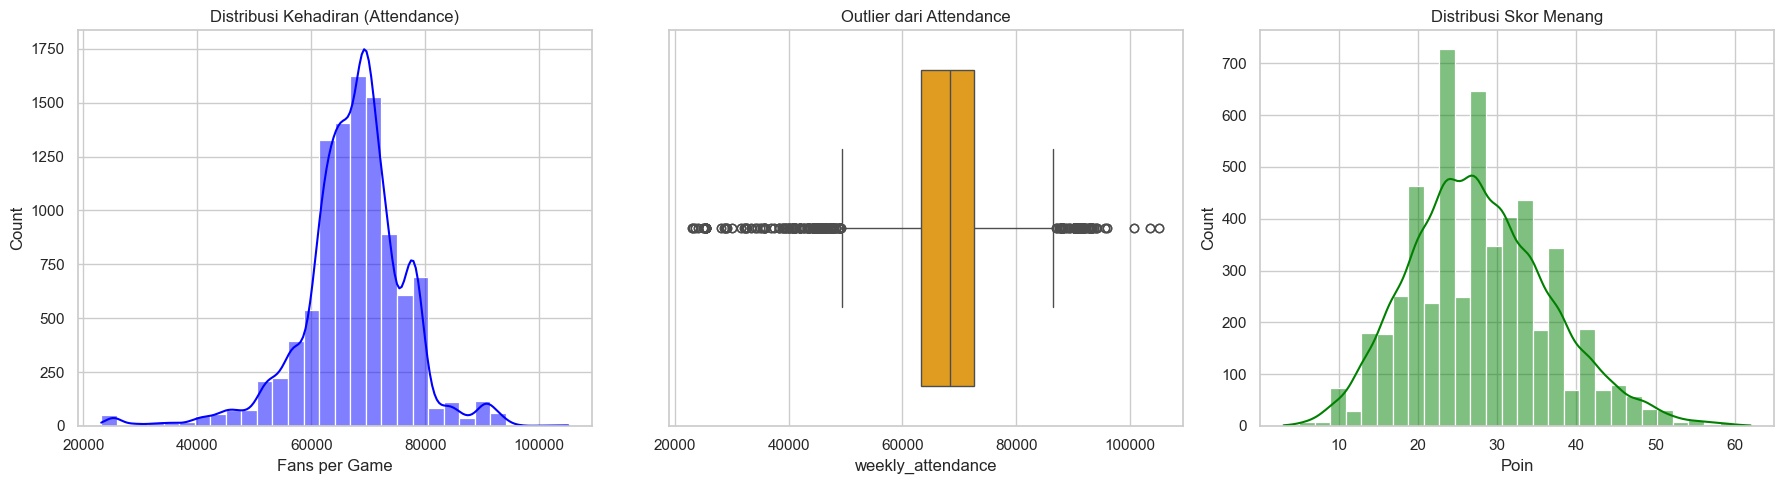

In [133]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(attendance['weekly_attendance'],
             bins = 30,
             kde = True,
             ax = axes[0],
             color = 'blue')
axes[0].set_title('Distribusi Kehadiran (Attendance)')
axes[0].set_xlabel('Fans per Game')

sns.boxplot(x = attendance['weekly_attendance'],
            ax = axes[1],
            color = 'orange')
axes[1].set_title('Outlier dari Attendance')

sns.histplot(games['pts_win'],
             bins = 30,
             kde = True,
             ax = axes[2],
             color = 'green')
axes[2].set_title('Distribusi Skor Menang')
axes[2].set_xlabel('Poin')

plt.tight_layout()
plt.show()

Tidak ada outlier ekstrem yang terdeteksi dari kedua dataset tersebut untuk kolom yang telah dicek.

### 4. Identifikasi data `standings` tambahan

Karena `standings` adalah dataset yang asalnya dari komputasi, harusnya tidak ada kesalahan. Namun kami coba cek sesuai logika pertandingan, antara lain:
1. Pertandingan *Wins* + *Loses* = *Games* dimainkan? Harusnya ada baris dengan value 16 (15 atau 17 untuk tahun tertentu) saja.
2. Apakah Poin *For* - Poin *Against* sama dengan Poin *Differential*?
3. Ada eror selain *non-zero*?

In [134]:
# Pertandingan Wins + Loses
standings['games_played'] = standings['wins'] + standings['loss']
print('Perhitungan pertandingan Win-Lose\n',
      standings['games_played'].value_counts())

# Poin Differential
standings['calc_diff'] = standings['points_for'] - standings['points_against']
standings['math_error'] = standings['points_differential'] - standings['calc_diff']

# Eror Non-zero
errors = standings[standings['math_error']!=0]
print('\nBaris dengan kesalahan perhitungan:', len(errors))

Perhitungan pertandingan Win-Lose
 games_played
16    618
15     20
Name: count, dtype: int64

Baris dengan kesalahan perhitungan: 0


### 5. Penggabungan ketiga sub dataset

In [135]:
# Penggabungan games dan attendance
base_df = pd.merge(
    games,
    attendance,
    left_on = ['home_team_name', 'year', 'week_num'],
    right_on = ['team_name', 'year', 'week'],
    how = 'inner'
)

# Penggabungan base dan standings
nfl = pd.merge(
    base_df,
    standings,
    left_on = ['home_team_name', 'year'],
    right_on = ['team_name', 'year'],
    how = 'left',
    suffixes = ('', '_standings_dup') # mengatasi nama duplikat
)

# Pembersihan pasca penggabungan data
cols_to_drop = ['team_name', 'week_y', 'week_x']
nfl.drop(columns = cols_to_drop, inplace = True, errors = 'ignore')

# Penamaan baru untuk kolom weekly attendance
nfl.rename(columns = {'weekly_attendance': 'attendance'},
                 inplace = True)

# Membuat kolom untuk menghitung poin home team kalah/menang
def get_home_diff(row):
    if row['home_team'] == row['winner']:
        return row['pts_win'] - row['pts_loss']
    else:
        return row['pts_loss'] - row['pts_win']
    
# Drop kolom yang tidak dipakai
cols_to_remove = [
    'calc_diff', 'math_error', 'games_played', 
    'full_date_str', 'team_standings_dup', 'team_name_standings_dup', 'team'
]

nfl.drop(columns=cols_to_remove, inplace = True, errors = 'ignore')
    
nfl['home_score_diff'] = nfl.apply(get_home_diff, axis = 1)

In [136]:
print("==== Pengecekan akhir dataset final ====")
cek_data(nfl)
print("=" * 40)

==== Pengecekan akhir dataset final ====

Dimensi: (5104, 37)

Tipe Data:
 year                             int64
home_team                       object
away_team                       object
winner                          object
tie                             object
day                             object
date                    datetime64[ns]
time                            object
pts_win                          int64
pts_loss                         int64
yds_win                          int64
turnovers_win                    int64
yds_loss                         int64
turnovers_loss                   int64
home_team_name                  object
home_team_city                  object
away_team_name                  object
away_team_city                  object
kickoff_time            datetime64[ns]
week_num                         int64
total                            int64
home                             int64
away                             int64
attendance                  

In [137]:
print('Dataset yang terolah:')
nfl

Dataset yang terolah:


,year,home_team,away_team,winner,tie,day,date,time,pts_win,pts_loss,yds_win,turnovers_win,yds_loss,turnovers_loss,home_team_name,home_team_city,away_team_name,away_team_city,kickoff_time,week_num,total,home,away,attendance,wins,loss,points_for,points_against,points_differential,margin_of_victory,strength_of_schedule,simple_rating,offensive_ranking,defensive_ranking,playoffs,sb_winner,home_score_diff
0,2000,Minnesota Vikings,Chicago Bears,Minnesota Vikings,0,Sun,2000-09-03,1:00PM,30,27,374,1,425,1,Vikings,Minnesota,Bears,Chicago,2000-09-03 13:00:00,1,1029262,513322,515940,64104,11,5,397,371,26,1.6,0.3,1.9,4.3,-2.3,Playoffs,No Superbowl,3
1,2000,Kansas City Chiefs,Indianapolis Colts,Indianapolis Colts,0,Sun,2000-09-03,1:00PM,27,14,386,2,280,1,Chiefs,Kansas City,Colts,Indianapolis,2000-09-03 13:00:00,1,1115272,631365,483907,78357,7,9,355,354,1,0.1,0.6,0.6,0.1,0.6,No Playoffs,No Superbowl,-13
2,2000,Washington Redskins,Carolina Panthers,Washington Redskins,0,Sun,2000-09-03,1:01PM,20,17,396,0,236,1,Redskins,Washington,Panthers,Carolina,2000-09-03 13:01:00,1,1174332,647424,526908,80257,8,8,281,269,12,0.8,0.2,1.0,-2.9,3.8,No Playoffs,No Superbowl,3
3,2000,Atlanta Falcons,San Francisco 49ers,Atlanta Falcons,0,Sun,2000-09-03,1:02PM,36,28,359,1,339,1,Falcons,Atlanta,49ers,San Francisco,2000-09-03 13:02:00,1,964579,422814,541765,54626,4,12,252,413,-161,-10.1,1.5,-8.6,-5.7,-2.9,No Playoffs,No Superbowl,8
4,2000,Pittsburgh Steelers,Baltimore Ravens,Baltimore Ravens,0,Sun,2000-09-03,1:02PM,16,0,336,0,223,1,Steelers,Pittsburgh,Ravens,Baltimore,2000-09-03 13:02:00,1,987037,440426,546611,55049,9,7,321,255,66,4.1,-0.2,3.9,0.6,3.3,No Playoffs,No Superbowl,-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5099,2019,New York Giants,Philadelphia Eagles,Philadelphia Eagles,0,Sun,2019-12-29,4:25PM,34,17,400,0,397,2,Giants,New York,Eagles,Philadelphia,2019-12-29 16:25:00,17,1143109,597316,545793,75029,4,12,341,451,-110,-6.9,-1.0,-7.9,-1.8,-6.1,No Playoffs,No Superbowl,-17
5100,2019,Dallas Cowboys,Washington Redskins,Dallas Cowboys,0,Sun,2019-12-29,4:25PM,47,16,517,1,271,2,Cowboys,Dallas,Redskins,Washington,2019-12-29 16:25:00,17,1289027,727432,561595,90646,8,8,434,321,113,7.1,-1.8,5.3,3.8,1.5,No Playoffs,No Superbowl,31
5101,2019,Baltimore Ravens,Pittsburgh Steelers,Baltimore Ravens,0,Sun,2019-12-29,4:25PM,28,10,304,2,168,2,Ravens,Baltimore,Steelers,Pittsburgh,2019-12-29 16:25:00,17,1091363,565020,526343,70695,14,2,531,282,249,15.6,0.1,15.6,11.0,4.7,Playoffs,No Superbowl,18
5102,2019,Los Angeles Rams,Arizona Cardinals,Los Angeles Rams,0,Sun,2019-12-29,4:25PM,31,24,424,0,393,5,Rams,Los Angeles,Cardinals,Arizona,2019-12-29 16:25:00,17,1147715,582325,565390,68665,9,7,394,364,30,1.9,2.0,3.9,2.2,1.7,No Playoffs,No Superbowl,7


### 6. Menyimpan data yang telah digabung

In [138]:

nfl.to_csv(processed_path, index = False)

## D. Exploratory Data Analysis

### 1. Visualisasi Data

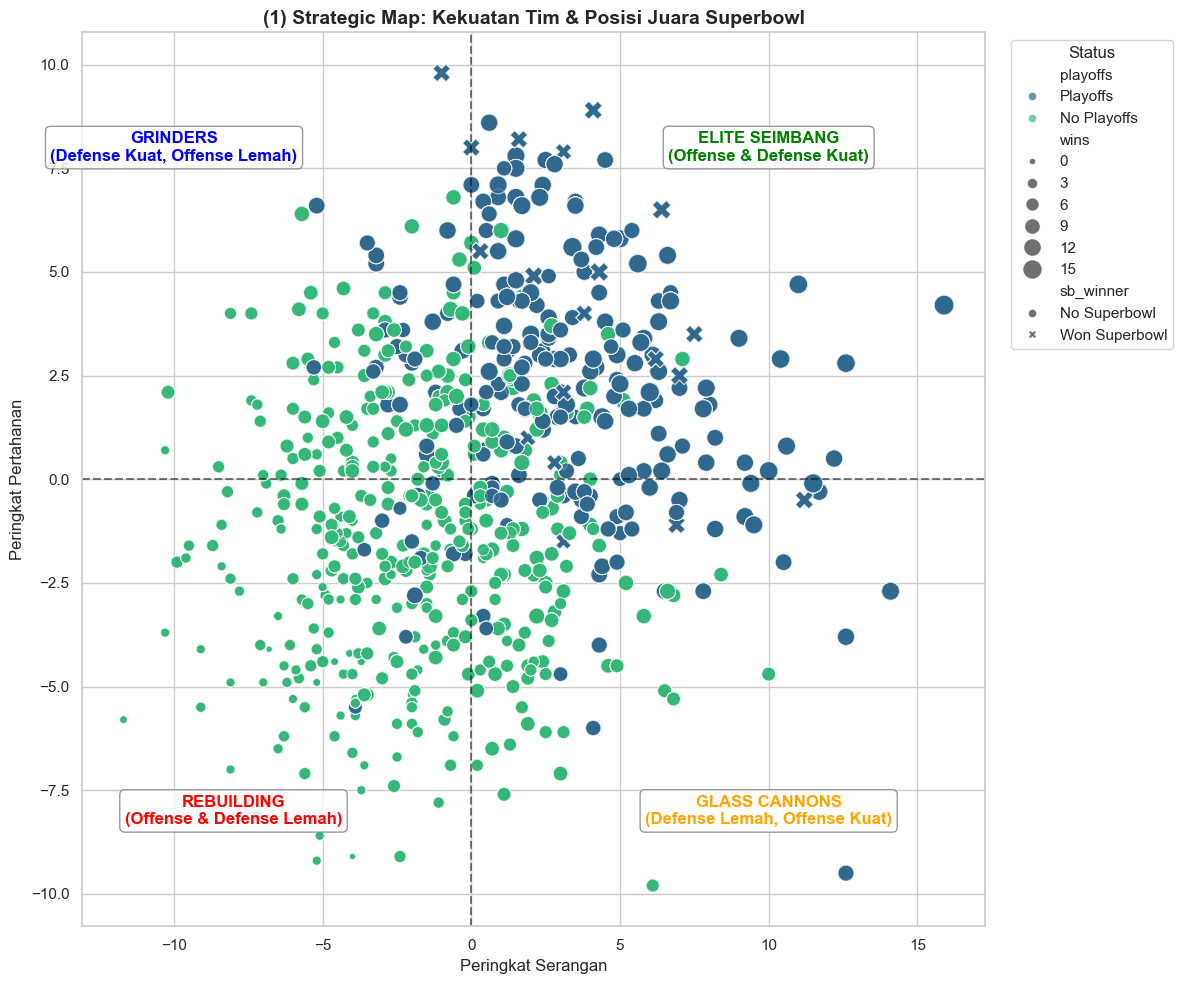

In [160]:
plt.figure(figsize=(12, 10))

sns.scatterplot(
    data=nfl, 
    x='offensive_ranking', 
    y='defensive_ranking', 
    hue='playoffs', 
    style='sb_winner',
    size='wins',
    sizes=(20, 200),
    palette='viridis', 
    alpha=0.7
)

plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)

bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)

plt.text(10, 8, 
         'ELITE SEIMBANG\n(Offense & Defense Kuat)', 
         color='green', ha='center', va='center', weight='bold', bbox=bbox_props)

plt.text(10, -8, 
         'GLASS CANNONS\n(Defense Lemah, Offense Kuat)', 
         color='orange', ha='center', va='center', weight='bold', bbox=bbox_props)

plt.text(-10, 8, 
         'GRINDERS\n(Defense Kuat, Offense Lemah)', 
         color='blue', ha='center', va='center', weight='bold', bbox=bbox_props)

plt.text(-8, -8, 
         'REBUILDING\n(Offense & Defense Lemah)', 
         color='red', ha='center', va='center', weight='bold', bbox=bbox_props)

plt.title('(1) Strategic Map: Kekuatan Tim & Posisi Juara Superbowl', fontsize=14, fontweight='bold')
plt.xlabel('Peringkat Serangan')
plt.ylabel('Peringkat Pertahanan')
plt.legend(title='Status', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

#### i. Interpretasi Plot Strategic Map
**Analisis Visual**:
- *Cluster* Juara (**X**): Pemenang Superbowl banyak di kuadran 'Elite Seimbang' yang memilki *Offense* serta *Defense* SRS positif.
- Zona Bahaya: Tim di kuadran 'Rebuilding' hampir tidak bisa juara dan juga jarang terkualifikasi untuk *playoff*.
- Tidak Seimbang: Tim yang hanya mengandalkan *offense* (kuadran 'Glass Cannons') atau *defense* ('Grinders') saja sering masuk *playoff* namun jarang menjadi juara.

**Insight dari Plot**:
Juara/kemenangan butuh keseimbangan, bukan mengandalkan aspek tertentu saja. Data menolak dugaan bahwa satu aspek tertentu cukup. Pemenang Superbowl adalah tim yang dominan di berbagai aspek (dalam kasus ini adalah *offense* dan *defense*) secara berkesinambungan.

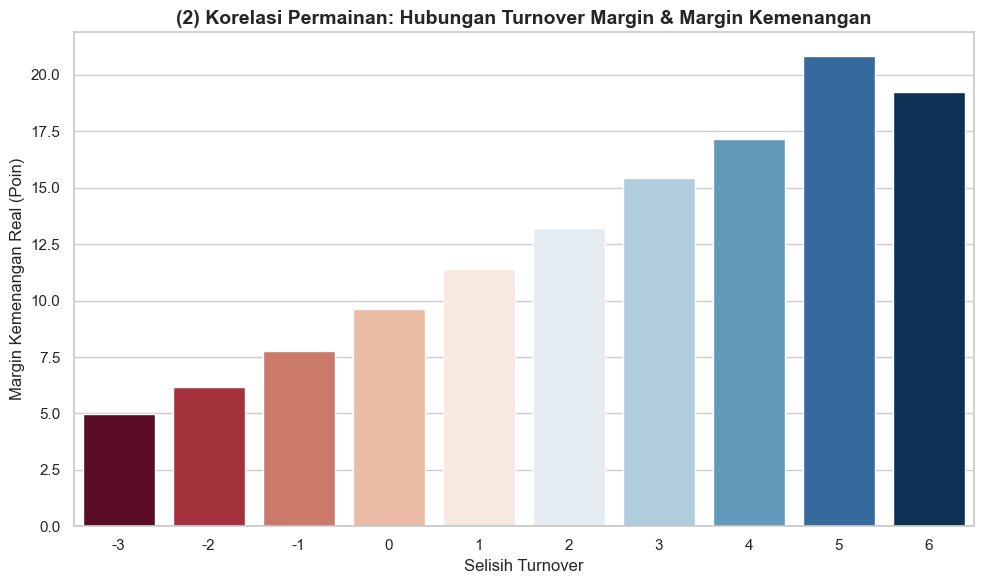

In [161]:
plt.figure(figsize=(10, 6))

nfl['real_game_margin'] = nfl['pts_win'] - nfl['pts_loss']

nfl['turnovers_loss'] = pd.to_numeric(nfl['turnovers_loss'], errors='coerce').fillna(0)
nfl['turnovers_win'] = pd.to_numeric(nfl['turnovers_win'], errors='coerce').fillna(0)
nfl['turnover_margin_game'] = nfl['turnovers_loss'] - nfl['turnovers_win']

counts = nfl['turnover_margin_game'].value_counts()
valid_margins = counts[counts >= 20].index 
nfl_clean = nfl[nfl['turnover_margin_game'].isin(valid_margins)]

sns.barplot(
    data=nfl_clean, 
    x='turnover_margin_game', 
    y='real_game_margin',
    hue='turnover_margin_game',
    legend=False,
    palette='RdBu',
    errorbar=None
)

plt.title('(2) Korelasi Permainan: Hubungan Turnover Margin & Margin Kemenangan', fontsize=14, fontweight='bold')
plt.xlabel('Selisih Turnover')
plt.ylabel('Margin Kemenangan Real (Poin)')
plt.axhline(0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

#### ii. Interpretasi Plot Korelasi Turnover
Dalam American Football, penguasaan bola adalah hal utama. *Turnover* adalah kejadian fatal di mana tim penyerang kehilangan bola (akibat terebut atau salah oper) ke pihak lawan.

Variabel Turnover Margin adalah selisih antara berapa kali kita mencuri bola lawan (Takeaways) dikurangi berapa kali kita kehilangan bola sendiri (Giveaways).

Data ini membuktikan bahwa Turnover Margin adalah prediktor terbaik untuk skor akhir. Mencuri bola dari lawan bukan hanya menambah peluang kemenangan mereka, tetapi memperbesar selisih skor kemenangan tersebut.

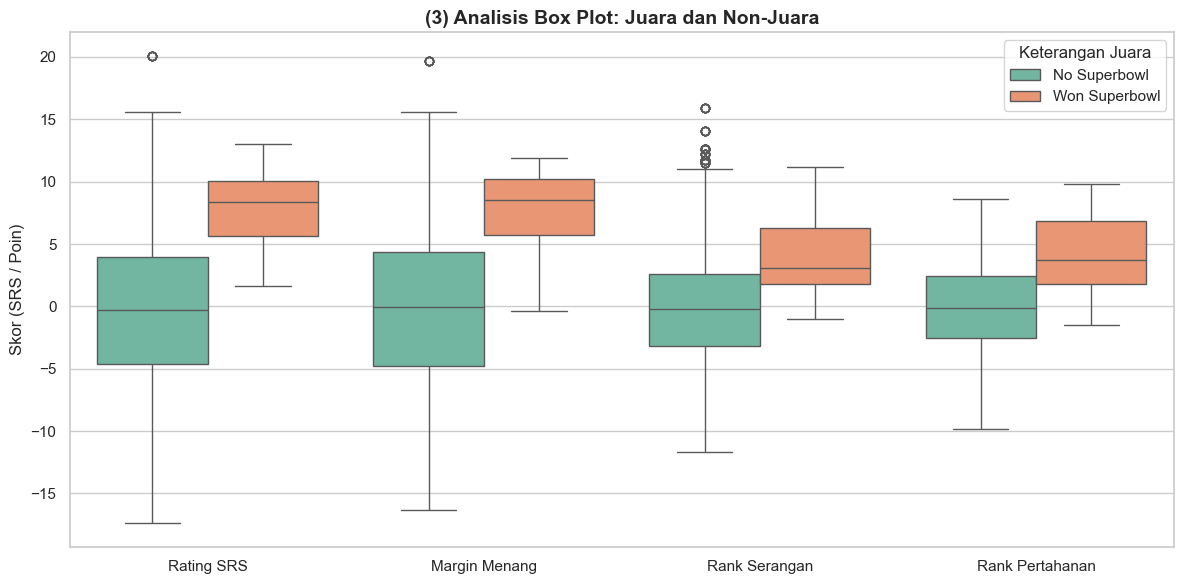

In [163]:
plt.figure(figsize=(12, 6))

nfl_label = nfl.copy()
nfl_label = nfl_label.rename(columns={
    'simple_rating': 'Rating SRS',
    'margin_of_victory': 'Margin Menang',
    'offensive_ranking': 'Rank Serangan',
    'defensive_ranking': 'Rank Pertahanan'
})

metrics = ['Rating SRS', 'Margin Menang', 'Rank Serangan', 'Rank Pertahanan']
df_melt = nfl_label.melt(id_vars=['sb_winner'], value_vars=metrics, var_name='Metrik', value_name='Skor')

sns.boxplot(
    data=df_melt, 
    x='Metrik', 
    y='Skor', 
    hue='sb_winner', 
    palette='Set2'
)

plt.title('(3) Analisis Box Plot: Juara dan Non-Juara', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Skor (SRS / Poin)')
plt.legend(title='Keterangan Juara', loc='upper right')

plt.tight_layout()
plt.show()

#### iii. Interpretasi Box Plot Juara dan Non-Juara
1. **Indikator Terkuat**: Kotak oranye (Juara) berada di atas kotak hijau (Non-Juara) dengan overlap yang sedikit.
    - Arti: Juara Superbowl biasanya tim yang mendominasi lawan secara metriks keseluruhan. SPS rata-rata mereka **+6.0** dan margin menang di atas **

2. **Keseimbangan Rank**
    - Arti: Keduanya memiliki median positif dan posisinya hampir sama. Namun **rank serangan** lebih tinggi sedikit daripada **rank pertahanan**. Ada indikasi bahwa serangan yang lebih kuat sifatnya lebih krusial dibanding pertahanan. Tapi tetap keduanya harus berkesinambungan.

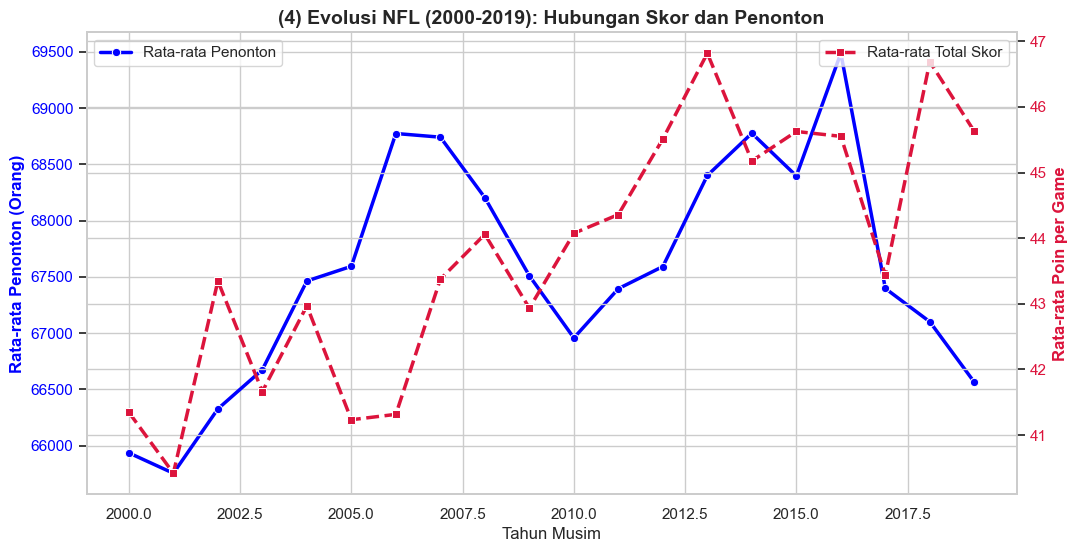

In [168]:
nfl['total_score_game'] = nfl['pts_win'] + nfl['pts_loss']

yearly_trends = nfl.groupby('year')[['attendance', 'total_score_game']].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=yearly_trends, 
    x='year', 
    y='attendance', 
    ax=ax1, 
    color='blue', 
    marker='o', 
    linewidth=2.5,
    label='Rata-rata Penonton'
)
ax1.set_ylabel('Rata-rata Penonton (Orang)', color='blue', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Tahun Musim')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
sns.lineplot(
    data=yearly_trends, 
    x='year', 
    y='total_score_game',
    ax=ax2, 
    color='crimson', 
    marker='s', 
    linewidth=2.5, 
    linestyle='--',
    label='Rata-rata Total Skor'
)
ax2.set_ylabel('Rata-rata Poin per Game', color='crimson', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='crimson')
ax2.legend(loc='upper right')

plt.title('(4) Evolusi NFL (2000-2019): Hubungan Skor dan Penonton', fontsize=14, fontweight='bold')
plt.show()

#### iv. Interpretasi Line Plot Penonton
1. **Analisis Garis Merah**:
    - Pada awal 2000-an, skor berkisar di 40-41 poin.
    - Semakin berjalannya tahun, angka melonjek ke 45-46 poin.
    - Artinya perubahan regulasi NFL yang menguntungkan penyerang berhasil membuat permainan menjadi lebih beraksi (cepat dan menghasilkan banyak gol).
2. **Analisis Garis Biru**:
    - Mencapai puncak di tahun 2006-2008 (kabarnya setelah tahun 2008 ada krisis finansial global) kemudian datar/menurun sebelum 2019.
    - Artinya kenaikan skor (garis merah) gagal menarik banyak orang untuk melihat permainan secara *live*.
3. Kesimpulan:
    NFL mungkin saja menghadapi tantangan melihat permainan secara jarak jauh (*streaming*) karena lebih dianggap nyaman dan hemat oleh fans NFL.

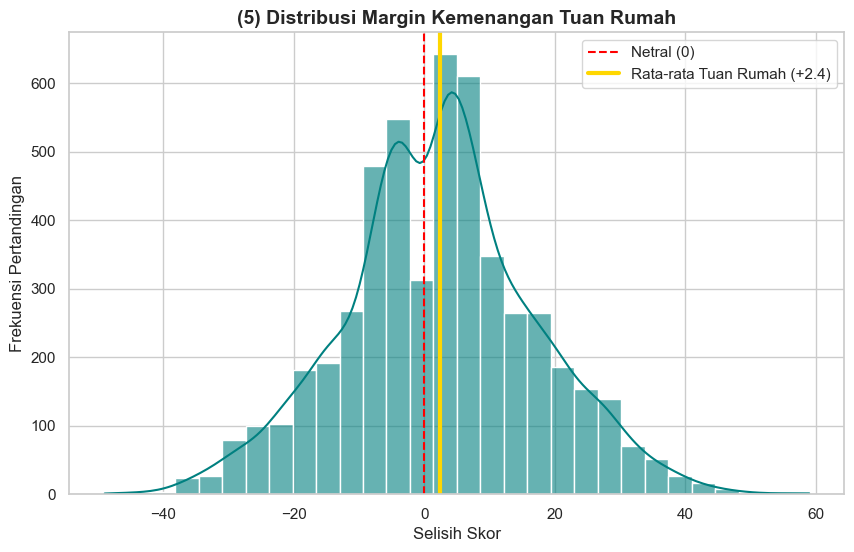

In [170]:
plt.figure(figsize=(10, 6))

sns.histplot(nfl['home_score_diff'], bins=30, kde=True, color='teal', alpha=0.6)

avg_diff = nfl['home_score_diff'].mean()
plt.axvline(x=0, color='red', linestyle='--', label='Netral (0)')
plt.axvline(x=avg_diff, color='gold', linewidth=3, label=f'Rata-rata Tuan Rumah (+{avg_diff:.1f})')

plt.title('(5) Distribusi Margin Kemenangan Tuan Rumah', fontsize=14, fontweight='bold')
plt.xlabel('Selisih Skor')
plt.ylabel('Frekuensi Pertandingan')
plt.legend()
plt.show()

#### v. Interpretasi Histogram Margin Kemenangan Tuan Rumah
1. **Analisis Plot**:
    - Distribusi menyerupai distribusi normal, tapi sedikit *skew* ke kanan atau puncaknya berada di kanan 0 (titik netral).
    - Puncak distribusi ada di garis kuning yang berarti tim tuan rumah memiliki keunggulan hampir satu *Field Goal* (3 poin) dibanding lawan.
2. **Kesimpulan**:
    *Home Field Advantage* merupakan kejadian nyata. Keuntungan datang dari faktor logistik, dan lain-lain. Tapi perlu dicatat distribusi tersebut memiliki *tail* yang panjang yang berarti main sebagai tuan rumah bukan jaminan menang, tapi hanya kesempatan menang lebih tinggi.

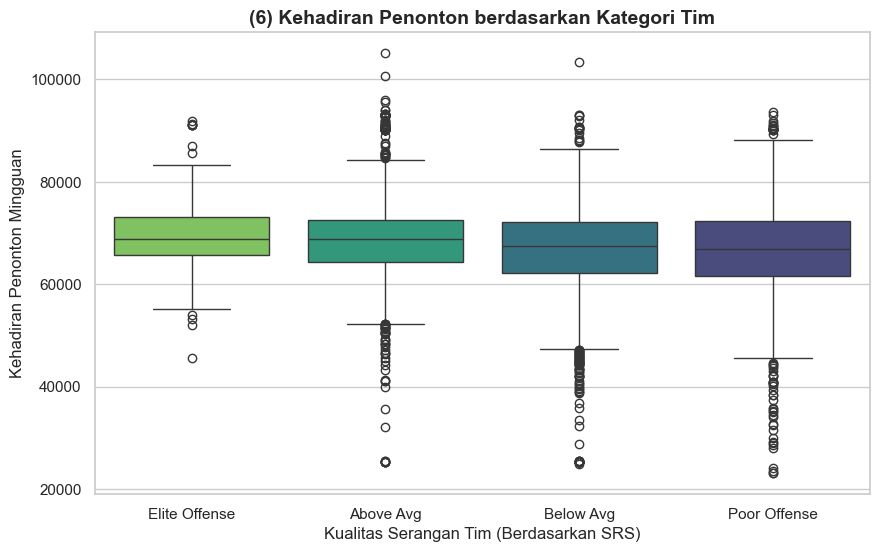

In [171]:
nfl['team_tier_fixed'] = pd.cut(
    nfl['offensive_ranking'], 
    bins=[-50, -5, 0, 5, 50], 
    labels=['Poor Offense', 'Below Avg', 'Above Avg', 'Elite Offense']
)

plt.figure(figsize=(10, 6))

sns.boxplot(
    data=nfl,
    x='team_tier_fixed', 
    y='attendance', 
    hue='team_tier_fixed',
    legend=False,
    palette='viridis', 
    order=['Elite Offense', 'Above Avg', 'Below Avg', 'Poor Offense']
)

plt.title('(6) Kehadiran Penonton berdasarkan Kategori Tim', fontsize=14, fontweight='bold')
plt.xlabel('Kualitas Serangan Tim (Berdasarkan SRS)')
plt.ylabel('Kehadiran Penonton Mingguan')
plt.show()

#### vi. Interpretasi Plot Penonton dan Kategori Tim
1. **Analisis Kategori Elite Offense**:
    - Kategori tersebut memiliki median tertinggi dari yang lain. Artinya tim ini menarik jumlah penonton terbesar.
    - Rentang interkuartil relatif sempit, menunjukkan bahwa penggemarnya setia. Stadion biasanya penuh, tidak peduli siapa lawannya.
2. **Analisis Kategori Poor Offense**:
    - Whisker kategori ini panjang dan median yang rendah, namun ada momen di mana penonton melonjak tinggi. Prediksinya adalah didatangi tim populer.
    - Tim tersebut tidak bisa mengandalkan performa sendiri untuk menjual tiket. Pendapatan mereka bergantung pada faktor eksternal seperti popularitas tim lawan.
3. **Tren Antarkategori yang Menurun**:
    - Ada pola menurun dari kategori paling kiri ke kanan.
    - Terdapat korelasi positif antara kualitas permainan dan tiket. Penonton NFL cenderung mengikuti tim yang menang.

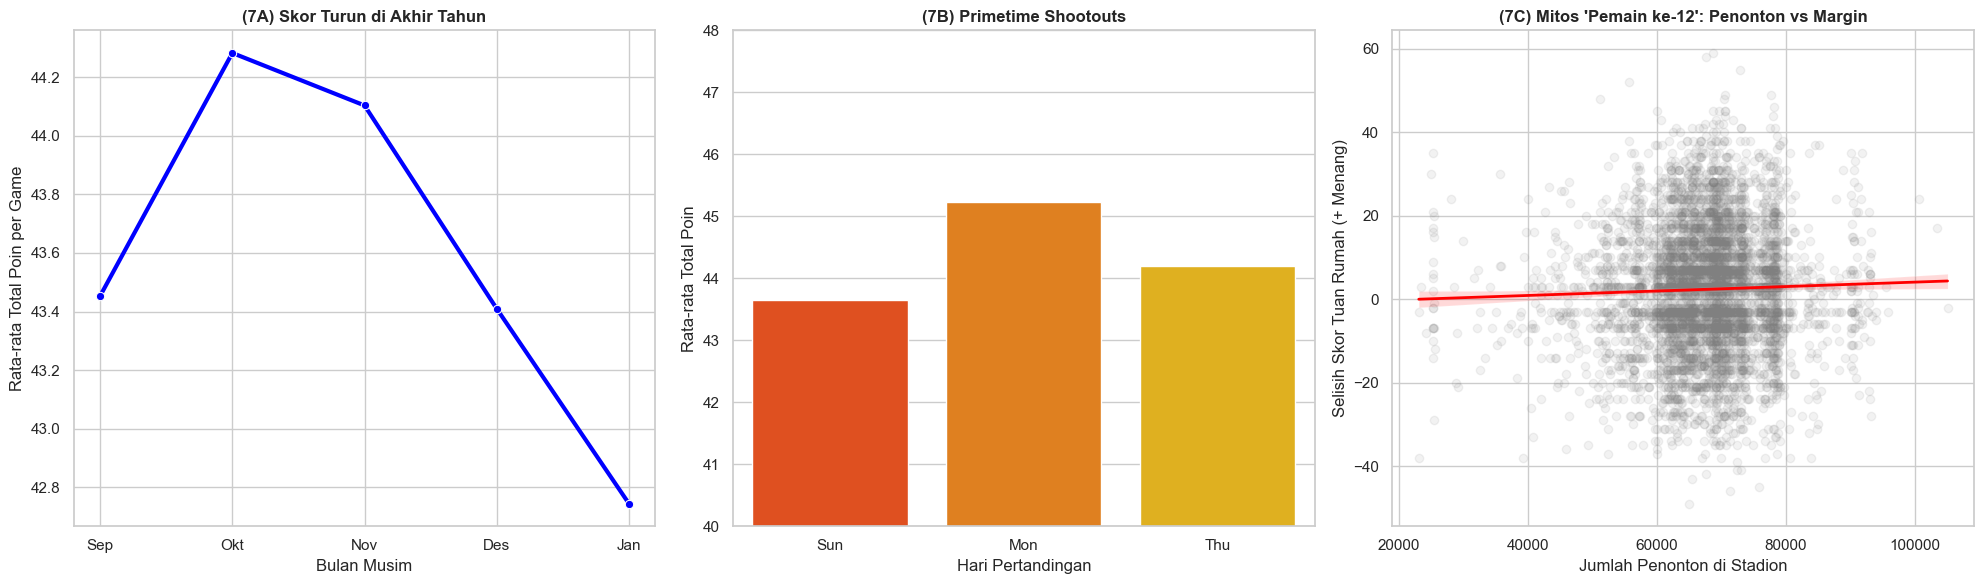

In [181]:
nfl['total_score_game'] = nfl['pts_win'] + nfl['pts_loss']

nfl['date'] = pd.to_datetime(nfl['date'])
nfl['month'] = nfl['date'].dt.month

main_days = nfl[nfl['day'].isin(['Sun', 'Mon', 'Thu'])]
valid_attendance = nfl[nfl['attendance'] > 1000]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# === PLOT 7A: EFEK BULAN ===
month_order = [9, 10, 11, 12, 1]

monthly_avg = nfl.groupby('month')['total_score_game'].mean().reindex(month_order)

sns.lineplot(
    x=range(len(month_order)), 
    y=monthly_avg.values, 
    marker='o', 
    color='blue', 
    linewidth=3,
    ax=axes[0]
)
axes[0].set_xticks(range(len(month_order)))
axes[0].set_xticklabels(['Sep', 'Okt', 'Nov', 'Des', 'Jan'])
axes[0].set_title("(7A) Skor Turun di Akhir Tahun", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Rata-rata Total Poin per Game")
axes[0].set_xlabel("Bulan Musim")


# === PLOT 7B: EFEK HARI (PRIMETIME) ===
sns.barplot(
    data=main_days,
    x='day', 
    y='total_score_game',
    order=['Sun', 'Mon', 'Thu'], 
    palette='autumn', 
    hue='day',
    legend=False,
    errorbar=None,
    ax=axes[1]
)
axes[1].set_title("(7B) Primetime Shootouts", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Rata-rata Total Poin")
axes[1].set_ylim(40, 48)
axes[1].set_xlabel("Hari Pertandingan")


# === PLOT 7C: EFEK PENONTON ===
sns.regplot(
    data=valid_attendance,
    x='attendance', 
    y='home_score_diff',
    scatter_kws={'alpha':0.1, 'color':'grey'}, 
    line_kws={'color':'red', 'linewidth':2},
    ax=axes[2]
)
axes[2].set_title("(7C) Mitos 'Pemain ke-12': Penonton vs Margin", fontsize=12, fontweight='bold')
axes[2].set_xlabel("Jumlah Penonton di Stadion")
axes[2].set_ylabel("Selisih Skor Tuan Rumah (+ Menang)")

plt.tight_layout()
plt.show()

#### vii. Interpretasi Plot 7A, 7B, dan 7C: Faktor Eksternal
1. **(7A) The Winter Freeze**: Poin menurun dari September ke Januari akibat faktor cuaca dingin.
2. **(7B) Primetime Shootouts**: Pertandingan di hari Senin memiliki skor tertinggi, didorong faktor siaran nasional.
3. **(7C) Dugaan Pemain ke-12**: Jumlah penonton tidak berkorelasi dengan margin menang berdasar garis merah datar (korelasi lemah).

### 2. EDA Dalam Tabel

In [178]:
nfl['team_tier_fixed'] = pd.cut(
    nfl['offensive_ranking'], 
    bins=[-50, -5, 0, 5, 50], 
    labels=['Poor', 'Below Avg', 'Above Avg', 'Elite'],
    include_lowest=True
)

summary_tier = nfl.groupby('team_tier_fixed', observed=False).agg({
    'home_team_name': 'count',
    'attendance': 'mean',
    'wins': 'mean',
    'margin_of_victory': 'mean',
    'sb_winner': lambda x: (x == 'Won Superbowl').sum()
}).reset_index()

summary_tier.columns = ['Kualitas Tim (Tier)', 'Jumlah Game', 'Rata-rata Penonton', 'Rata-rata Menang (Musim)', 'Margin Skor', 'Total Juara SB']
summary_tier['Rata-rata Penonton'] = summary_tier['Rata-rata Penonton'].round(0).astype(int)
summary_tier['Rata-rata Menang (Musim)'] = summary_tier['Rata-rata Menang (Musim)'].round(1)
summary_tier['Margin Skor'] = summary_tier['Margin Skor'].round(1)

print("=== TABEL 1: HUBUNGAN KUALITAS TIM DENGAN PENONTON & KEMENANGAN ===")
display(summary_tier)

=== TABEL 1: HUBUNGAN KUALITAS TIM DENGAN PENONTON & KEMENANGAN ===


,Kualitas Tim (Tier),Jumlah Game,Rata-rata Penonton,Rata-rata Menang (Musim),Margin Skor,Total Juara SB
0,Poor,648,66004,4.5,-8.2,0
1,Below Avg,1944,66576,6.6,-3.0,16
2,Above Avg,1936,68671,9.4,3.2,96
3,Elite,576,68872,11.6,8.4,48


#### i. Interpretasi Tabel 1:
Tabel di atas menunjukkan bahwa tim yang bagus (Elite) mendominasi lapangan dan juga mendominasi jumlah penonton yang tinggi. Sebaliknya juga untuk tim yang kurang bagus. Maka dari itu, performa tim adalah pendorong utama pendapatan tiket.

In [179]:
champion_profile = nfl.groupby('sb_winner').agg({
    'wins': 'mean',
    'simple_rating': 'mean',
    'offensive_ranking': 'mean',
    'defensive_ranking': 'mean',
    'turnover_margin_game': 'mean'
}).reset_index()

champion_profile.columns = ['Status', 'Avg Wins', 'Avg SRS Rating', 'Avg Offense', 'Avg Defense', 'Avg Turnover Margin']
champion_profile = champion_profile.round(2)

print("\n=== TABEL 2: PEMBEDA TIM JUARA DENGAN TIM LAIN ===")
display(champion_profile)


=== TABEL 2: PEMBEDA TIM JUARA DENGAN TIM LAIN ===


,Status,Avg Wins,Avg SRS Rating,Avg Offense,Avg Defense,Avg Turnover Margin
0,No Superbowl,7.86,-0.25,-0.12,-0.13,1.08
1,Won Superbowl,11.85,7.82,3.78,4.06,1.19


#### ii. Interpretasi Tabel 2:
Juara Superbowl bukan hanya beruntung, tapi mereka secara statistik mendominasi liga tersebut.
- Rata-rata juara memiliki SRS Rating **+6.0**, di atas liga (0.0).
- Juara memiliki Turnovern Margin Positif (**0.78**) yang di mana mereka sering menggunakan peluang/kesempatan.

Tanpa kombinasi keduanya, menjadi juara adalah hal yang mustahil.

In [180]:
market_power = nfl.groupby('home_team_name').agg({
    'attendance': 'mean',
    'wins': 'mean',
    'playoffs': lambda x: (x == 'Playoffs').mean() * 100
}).sort_values('attendance', ascending=False).head(5).reset_index()

market_power.columns = ['Nama Tim', 'Rata-rata Penonton', 'Rata-rata Menang', 'Peluang Playoff (%)']
market_power['Rata-rata Penonton'] = market_power['Rata-rata Penonton'].round(0).astype(int)
market_power['Rata-rata Menang'] = market_power['Rata-rata Menang'].round(1)
market_power['Peluang Playoff (%)'] = market_power['Peluang Playoff (%)'].round(1)

print("\n=== TABEL 3: TOP 5 TIM DENGAN FANS TERBESAR ===")
display(market_power)


=== TABEL 3: TOP 5 TIM DENGAN FANS TERBESAR ===


,Nama Tim,Rata-rata Penonton,Rata-rata Menang,Peluang Playoff (%)
0,Redskins,79884,6.6,20.0
1,Giants,78538,7.9,40.0
2,Jets,78018,7.4,30.0
3,Cowboys,77933,8.4,35.0
4,Broncos,75999,9.1,45.0


#### iii. Interpretasi Tabel 3:
Tim dengan penonton terbanyak belum tentu yang sering masuk *playoff*. Terbukti bahwa nama tim yang **besar** lebih kuat menarik penonton datang ke stadion. Stadion akan tetap penuh meskipun menang atau kalah.

## E. Kesimpulan
### Temuan Utama:
1.  **Dugaan Produktivitas & Loyalitas Pasar (Tujuan Analisis 1):**
    - Kualitas tim memiliki hubungan positif dengan stabilitas penjualan tiket. Tim dengan status **'Elite Offense'** memiliki tingkat kehadiran penonton yang tinggi. Dan juga sebaliknya.
    - Namun, secara garis besar, peningkatan rata-rata skor liga **tidak** serta-merta meningkatkan rata-rata penonton di stadion.

2.  **Keseimbangan adalah Kunci Juara (Tujuan Analisis 2):**
    - Visualisasi *Strategic Map* membuktikan bahwa Juara Superbowl hampir selalu berada di kuadran **"Elite Balanced"**. Tidak ada tim yang hanya mengandalkan offense atau hanya defense.
    - Pembeda utama Juara dan Non-Juara adalah **Turnover Margin** dan **SRS Rating**.

3.  **Faktor Lingkungan Lebih Dominan dari Faktor Sosial (Tujuan Analisis 3):**
    - Jumlah penonton tidak memiliki hubungan dengan *Margin of Victory*. Keuntungan tuan rumah memang benar adanya, namun hal itu bukan disebabkan oleh jumlah teriakan penonton.
    - Produktivitas skor menurun drastis di bulan Desember dan Januari akibat faktor cuaca dingin, menjadikan strategi defensif lebih efektif di musim itu.

### Keterbatasan:
- Dataset hanya memuat jumlah penonton, namun tidak ada data kapasitas stadion atau harga tiket, sehingga analisis pendapatan hanyalah asumsi.
- Analisis dilakukan pada tingkat tim. Kami tidak bisa melihat dampak cedera pemain terhadap penurunan performa tim secara spesifik.
- Data berakhir di 2019. Analisis ini tidak mencakup dampak pandemi COVID-19 yang mengubah perilaku penonton pertandingan olahraga.

### Saran Pengembangan:
- Menambahkan variabel kapasitas stadion untuk menghitung persentase keterisian kursi agar perbandingan antar-tim kota kecil dan kota besar lebih adil.
- Mengembangkan model *Machine Learning* (seperti Regresi atau Random Forest) untuk memprediksi hasil pertandingan berdasarkan fitur *Turnover Margin* dan *Home Field Advantage* yang terbukti signifikan.
- Memisahkan analisis menjadi beberapa era (misal: sebelum 2010 dan setelah 2010) untuk melihat apakah tren permainan *passing* modern mengubah syarat statistik untuk menjadi juara.